# Stratégia na trhu

V tomto dokumente popisuje stratégie pre získanie priazne zákazníkov z jednotlivých skupín ako aj optimalizácia pre získanie najväčieho podielu na trhu, prostredníctvom genetického algoritmu.


In [46]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from dataclasses import dataclass
from typing import override, Any
from random import Random

In [7]:
%store -r marketing
%store -r improvements

### Trh

Premenné majú vplyv na rozhodnutie zákazníkov:

  - Priemerná cena na trhu
  - Predajná cena produktu
  - Modifikátor výskumu
  - Výnos marketingu

In [32]:
@dataclass
class Parameter:
    name: str
    min: float
    max: float


minimum_price = 250
maximum_price = 15000

parameters = [
    Parameter("average_price", minimum_price, maximum_price),
    Parameter("product_price", minimum_price, maximum_price),
    Parameter("research_modifier", 0, float(np.sum(improvements["modifier"]))),
    Parameter("marketing_yield", 0, 7000),
]

@dataclass
class Instance:
    average_price: float = 0
    product_price: float = 0
    research_modifier: float = 0
    marketing_yield: float = 0

    @staticmethod
    def create_random(random: Random):
        instance = Instance()

        for parameter in parameters:
            value = random.uniform(parameter.min, parameter.max)
            setattr(instance, parameter.name, value)

        return instance

    def mutate(self, random: Random):
        parameter = random.choice(parameters)
        range = (parameter.max - parameter.min) * 0.25
        value = getattr(self, parameter.name) + random.uniform(-range, range)
        setattr(self, parameter.name, max(parameter.min, min(parameter.max, value)))

    @staticmethod
    def crossover(random: Random, a: "Instance", b: "Instance"):
        result = Instance()

        for parameter in parameters:
            parent = a if random.random() > 0.5 else b
            value = getattr(parent, parameter.name)
            setattr(result, parameter.name, value)

        return result

Preferencie zákazníkov:

  - $40\%$ ⇒ nízka cena
  - $25\%$ ⇒ primerná cena
  - $20\%$ ⇒ vysoká cena
  - $15\%$ ⇒ inovácie

In [56]:
class CustomerType:
    name: str
    market_share: float
    marketing_coef: float

    def _get_price_weight(self, instance: Instance) -> float: ...
    def _get_marketing_weight(self, instance: Instance) -> float:

        return (1 + instance.marketing_yield / 10000) * self.marketing_coef

    def get_weight(self, instance: Instance):
        if instance.product_price > 15000:
            return 0
        return self._get_price_weight(instance) * self._get_marketing_weight(instance)


class LowPriceCustomer(CustomerType):
    name = "low_price"
    market_share = 0.4

    marketing_coef = 0.4

    @override
    def _get_price_weight(self, instance: Instance) -> float:
        if instance.product_price > instance.average_price * 1.25:
            return 0

        return (instance.average_price / instance.product_price) ** 2


class AveragePriceCustomer(CustomerType):
    name = "average_price"
    market_share = 0.25

    marketing_coef = 1

    @override
    def _get_price_weight(self, instance: Instance) -> float:
        if instance.product_price < instance.average_price * 1.5:
            return 0.1
        return 0.5 + instance.average_price / instance.product_price + 0.8 * instance.research_modifier


class HighPriceCustomer(CustomerType):
    name = "high_price"
    market_share = 0.2

    marketing_coef = 1.25

    @override
    def _get_price_weight(self, instance: Instance) -> float:
        if instance.product_price < instance.average_price * 1.5:
            return (instance.product_price / instance.average_price) ** 2 / 1000 + instance.research_modifier
        return (instance.product_price / instance.average_price) ** 2 + instance.research_modifier


class ResearchCustomer(CustomerType):
    name = "research"
    market_share = 0.15

    marketing_coef = 1.15

    @override
    def _get_price_weight(self, instance: Instance) -> float:
        if instance.research_modifier == 0:
            return 0
        return instance.average_price / instance.product_price + 1.2 * instance.research_modifier


customer_types = [
    LowPriceCustomer(),
    AveragePriceCustomer(),
    HighPriceCustomer(),
    ResearchCustomer(),
]

### Správanie zákazníkov

/tmp/ipykernel_202928/3897777695.py:12: RuntimeWarning: invalid value encountered in divide
  market[customer_type.name] = strategy / np.max(strategy)
/tmp/ipykernel_202928/3897777695.py:12: RuntimeWarning: invalid value encountered in divide
  market[customer_type.name] = strategy / np.max(strategy)
/tmp/ipykernel_202928/3897777695.py:12: RuntimeWarning: invalid value encountered in divide
  market[customer_type.name] = strategy / np.max(strategy)
/tmp/ipykernel_202928/3897777695.py:12: RuntimeWarning: invalid value encountered in divide
  market[customer_type.name] = strategy / np.max(strategy)
/tmp/ipykernel_202928/3897777695.py:12: RuntimeWarning: invalid value encountered in divide
  market[customer_type.name] = strategy / np.max(strategy)
/mnt/solid/Code/Skola/PAM/PAM-simulation/.venv/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:580: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`)

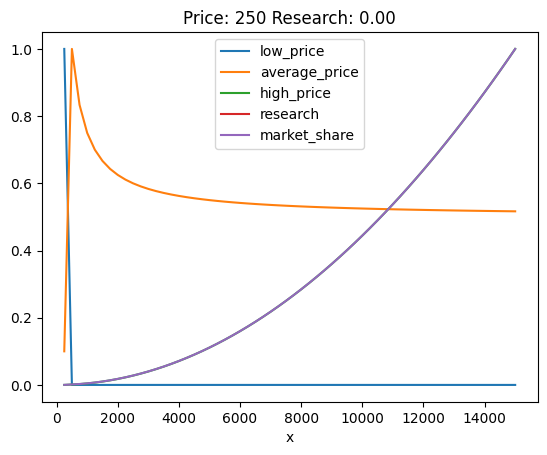

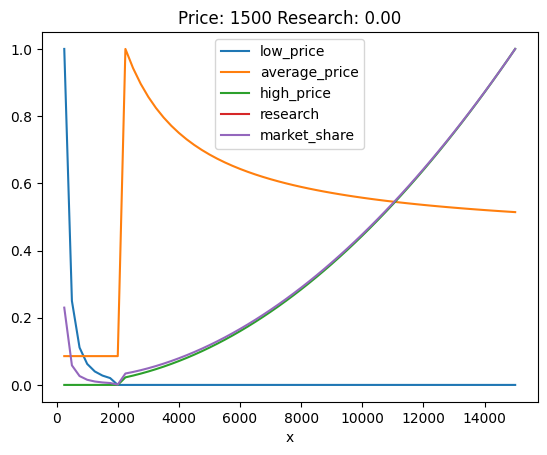

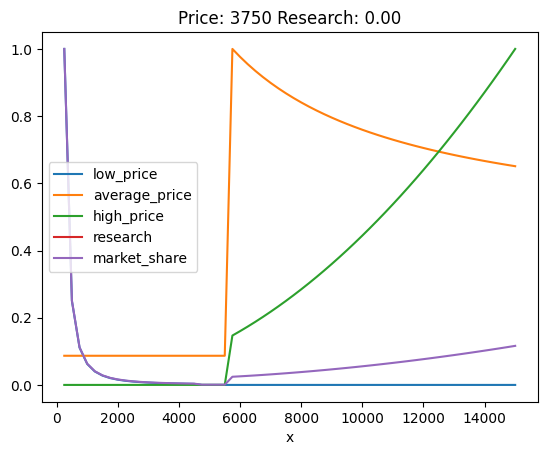

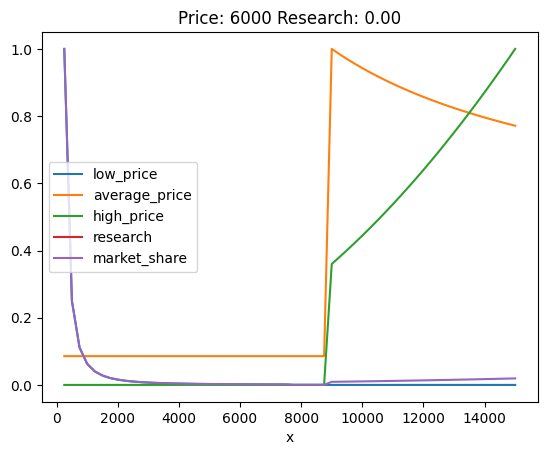

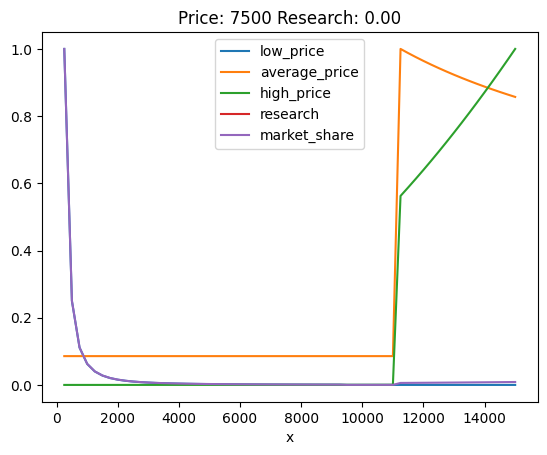

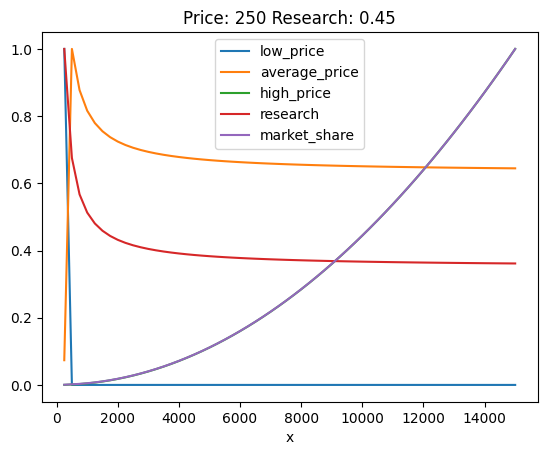

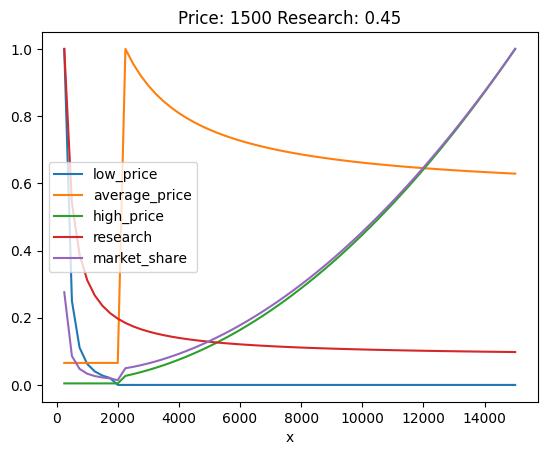

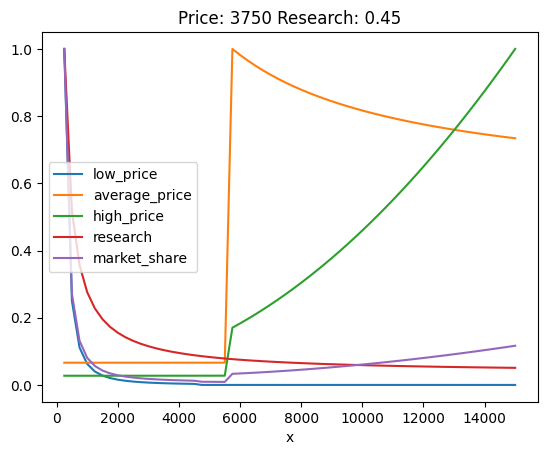

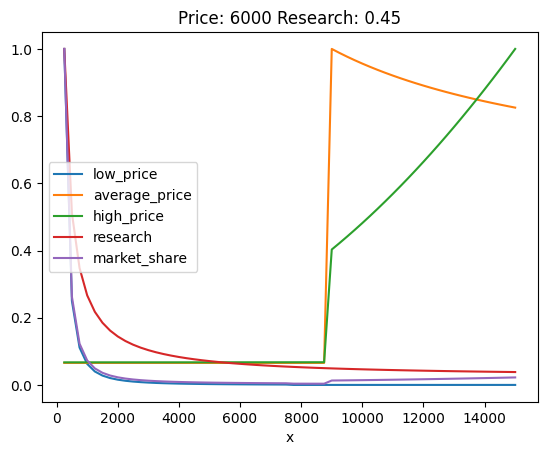

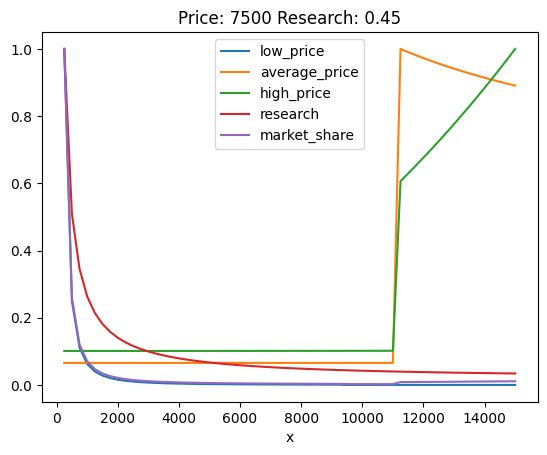

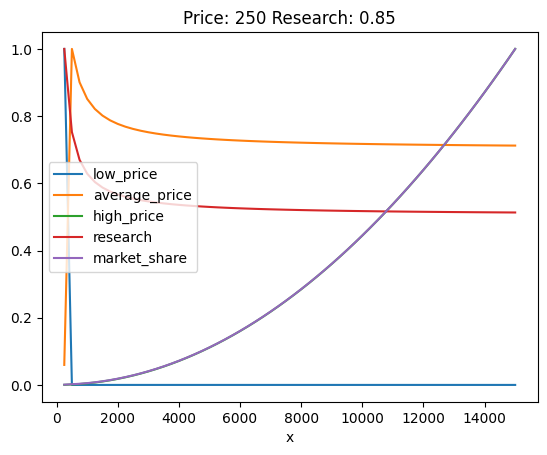

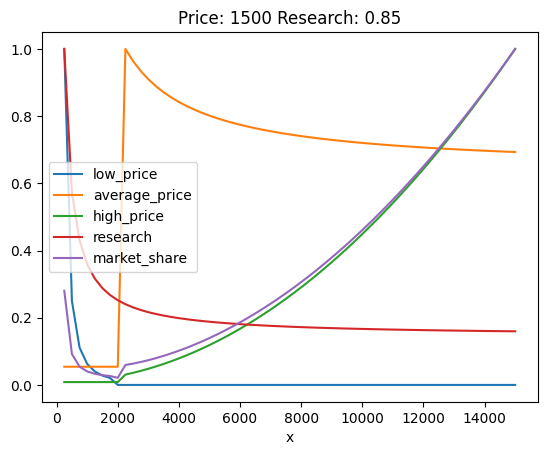

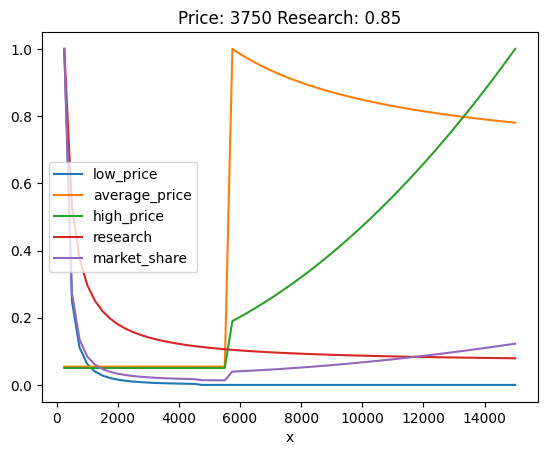

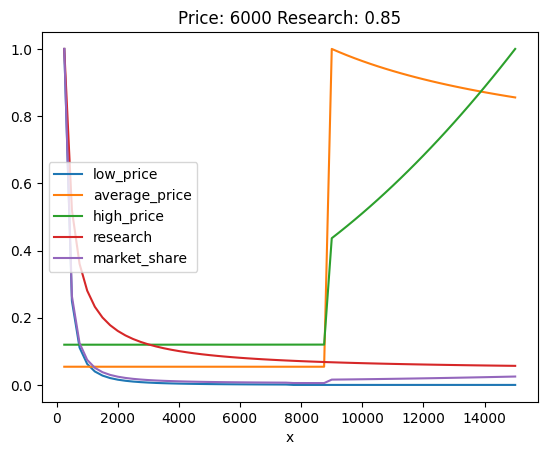

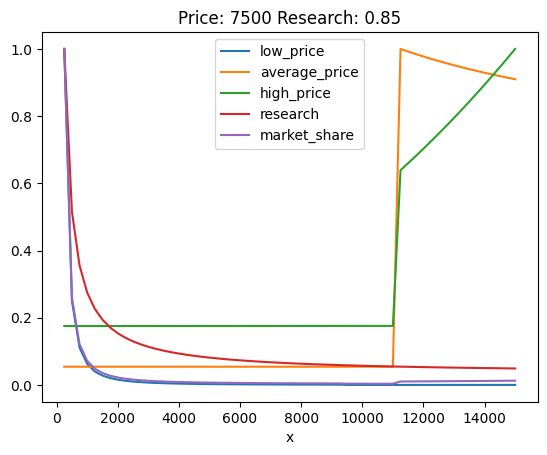

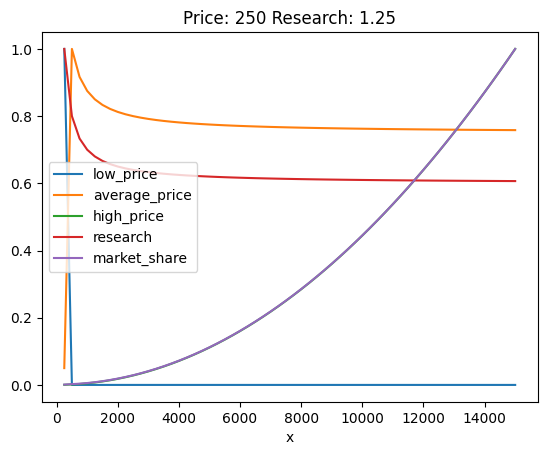

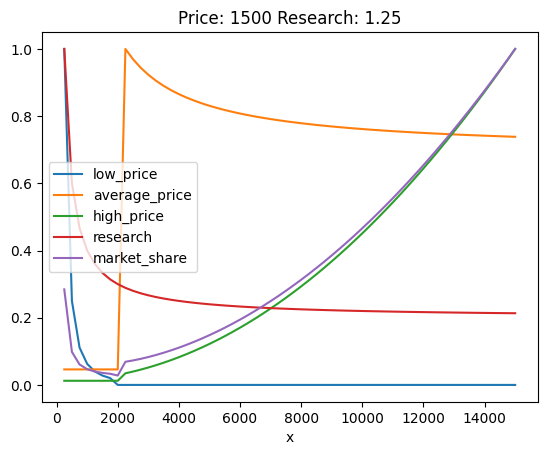

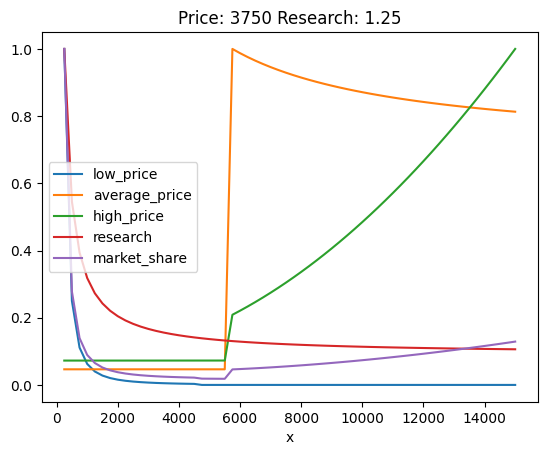

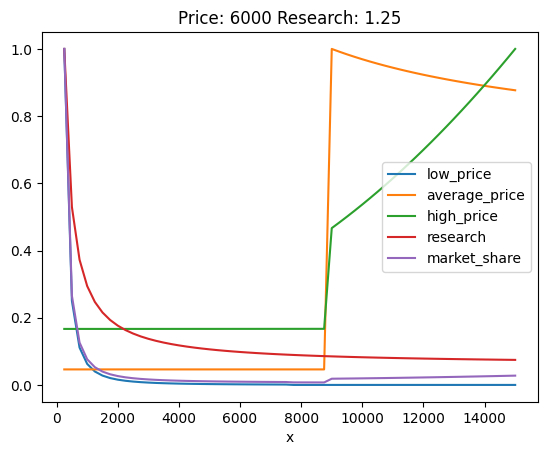

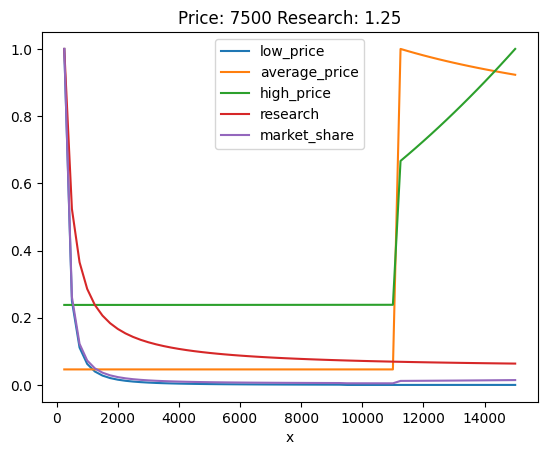

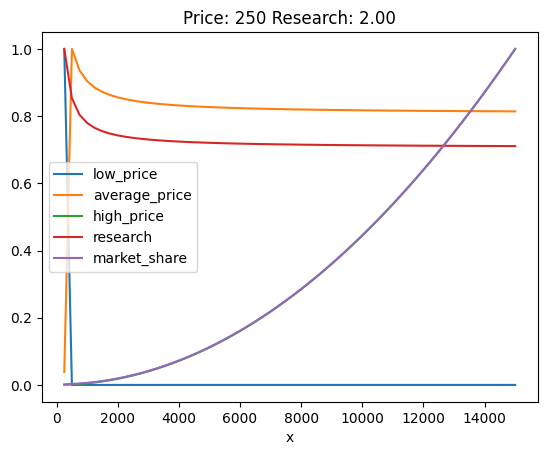

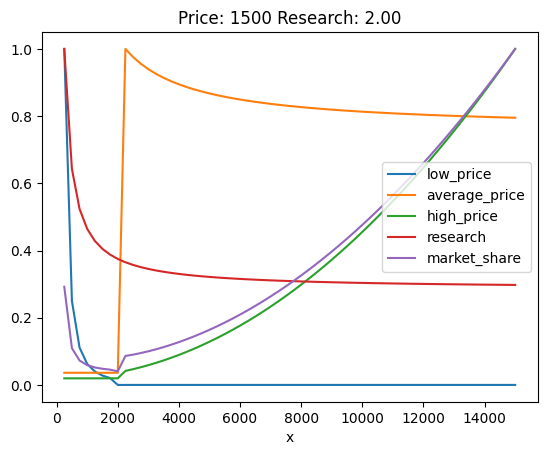

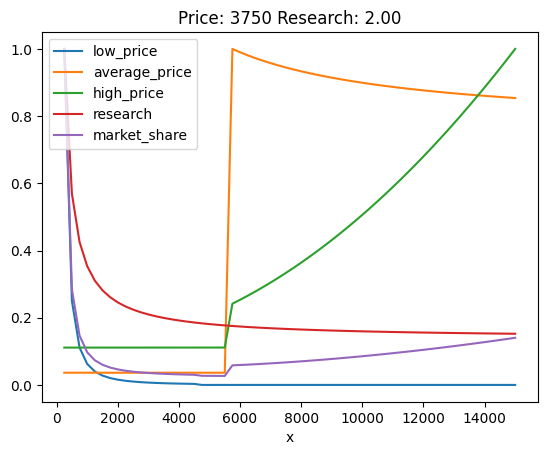

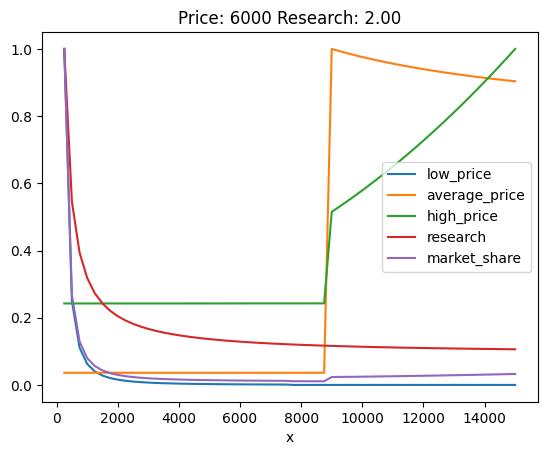

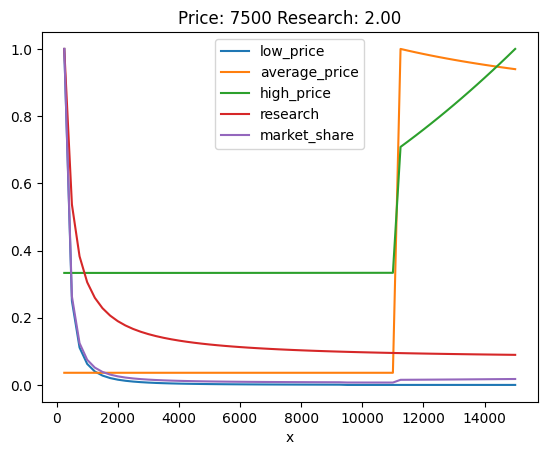

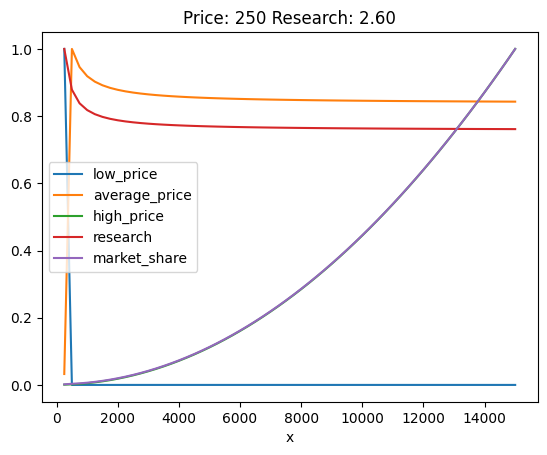

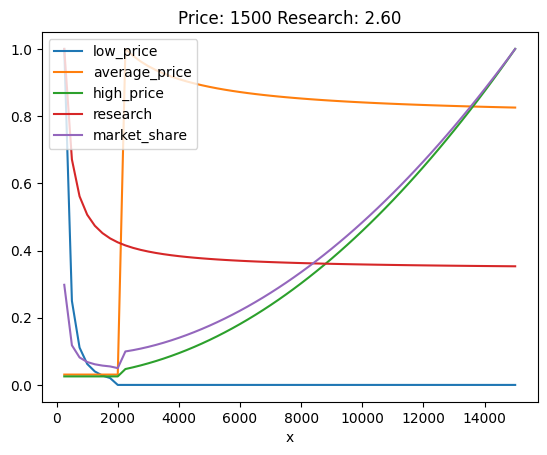

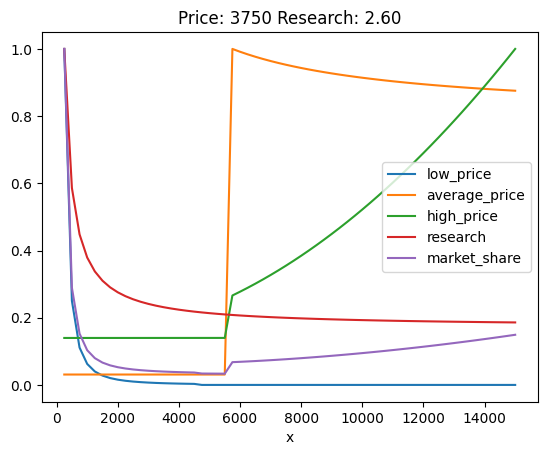

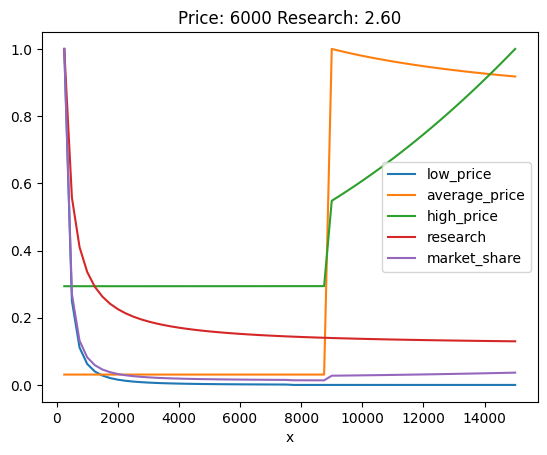

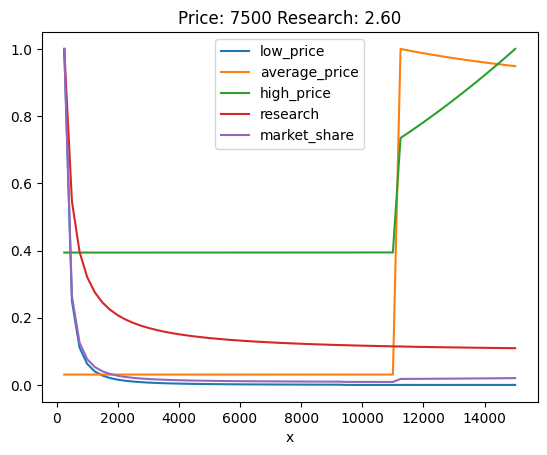

In [82]:
def fitness_per_cost(title: str, instance: Instance):
    market = pd.DataFrame({"x": np.arange(start=minimum_price, stop=maximum_price + 1, step=250)})
    for customer_type in customer_types:
        strategy: list[float] = []

        for x in market["x"]:
            instance.product_price = x
            result = customer_type.get_weight(instance)
            strategy.append(result)

        strategy = np.array(strategy, dtype=np.float32)
        market[customer_type.name] = strategy / np.max(strategy)

    strategy: list[float] = []
    for x in market["x"]:
        instance.product_price = x
        result = sum([type.get_weight(instance) * type.market_share for type in customer_types])
        strategy.append(result)

    market["market_share"] = np.array(strategy) / np.max(strategy)
    market.set_index("x", inplace=True)
    market.plot(title=title)


for research in [0, 0.45, 0.85, 1.25, 2, 2.6]:
    for price in [minimum_price, maximum_price * 0.1, maximum_price * 0.25, maximum_price * 0.4, maximum_price* 0.5]:
        instance = Instance(research_modifier=research, average_price=price)
        fitness_per_cost(f"Price: {instance.average_price:.0f} Research: {instance.research_modifier:.2f}", instance)

### Pri ideálnych podmienkach trhu

V tejto sekcií sú optimalizované parametre pri ideálnych podmienkach na trhu.

In [57]:
from typing import Callable


def optimize(random: Random, invariant: Callable[[Instance], Any] | None, fitness: Callable[[Instance], float]):
    population_size = 25
    population = [Instance.create_random(random) for _ in range(population_size)]
    epoch = 0

    def evaluate_population():
        if invariant is not None:
            for instance in population:
                invariant(instance)

        population.sort(key=fitness, reverse=True)

    evaluate_population()

    for _ in range(50):
        epoch += 1
        new_population: list[Instance] = population[0 : int(population_size * 0.2)]
        parents = population[0 : int(population_size * 0.3)]

        while len(new_population) < population_size:
            a = random.choice(parents)
            b = a
            while a is b:
                b = random.choice(parents)

            new_instance = Instance.crossover(random, a, b)
            new_instance.mutate(random)
            new_population.append(new_instance)

        population = new_population
        evaluate_population()

    return population[0]


In [58]:

random = Random(8045112)
for customer_type in customer_types:
    print(f"Optimizing for {customer_type.name}")
    print(f"  {optimize(random, None, customer_type.get_weight)}") 

print(f"Optimizing for all")
print(f"  {optimize(random, None, lambda instance: sum([type.get_weight(instance) * type.market_share for type in customer_types]))}") 

Optimizing for low_price
  Instance(average_price=15000, product_price=250, research_modifier=2.3526514153704343, marketing_yield=7000)
Optimizing for average_price
  Instance(average_price=5383.781978051128, product_price=8076.879238539747, research_modifier=2.6, marketing_yield=7000)
Optimizing for high_price
  Instance(average_price=250, product_price=15000, research_modifier=2.6, marketing_yield=7000)
Optimizing for research
  Instance(average_price=15000, product_price=250, research_modifier=2.6, marketing_yield=7000)
Optimizing for all
  Instance(average_price=15000, product_price=250, research_modifier=2.6, marketing_yield=7000)


  - Nízka cena ⇒ je najlepšie minimalizovať cenu a maximalizovať priemernú cenu, výskum nemá žiadny vplyv
  - Nriemerna cena ⇒ je najlepšie držať pomer ceny a priemernej ceny v hodnote 1.5
  - Vysoká cena ⇒ je najlepšie minimalizovať priemernú cenu a maximalizovať cenu produktu
  - Inovácie ⇒ je najlepšie minimalizovať cenu produktu a maximalizovať priemernú cenu

### Pri rôznych priemerných cenách

V tejto sekcií sú optimalizované stratégie pre rôzne priemerné ceny na trhu

In [ ]:
market = pd.DataFrame({ "x": np.arange(start=minimum_price, stop=maximum_price+1, step=250) })

random = Random(5061674)
for customer_type in customer_types:
    strategy: list[float] = []

    for x in market["x"]:
        result = optimize(random, lambda v: setattr(v, "average_price", x), customer_type.get_weight)
        strategy.append(result.product_price)

    market[customer_type.name] = strategy

strategy: list[float] = []
for x in market["x"]:
    result = optimize(random, lambda v: setattr(v, "average_price", x), lambda instance: sum([type.get_weight(instance) * type.market_share for type in customer_types]))
    strategy.append(result.product_price)

market["all"] = strategy

market.set_index("x", inplace=True)
market

,low_price,average_price,high_price,research,all
x,,,,,
250,250,402.972318,15000,250,15000
500,250,830.684600,15000,250,15000
750,250,1127.938812,15000,250,15000
1000,250,1500.073981,15000,250,15000
1250,250,1886.910487,15000,250,15000
1500,250,2300.407776,15000,250,15000
1750,250,2657.138833,15000,250,15000
2000,250,3044.475990,15000,250,15000
2250,250,3390.337802,15000,250,15000


<Axes: xlabel='x'>

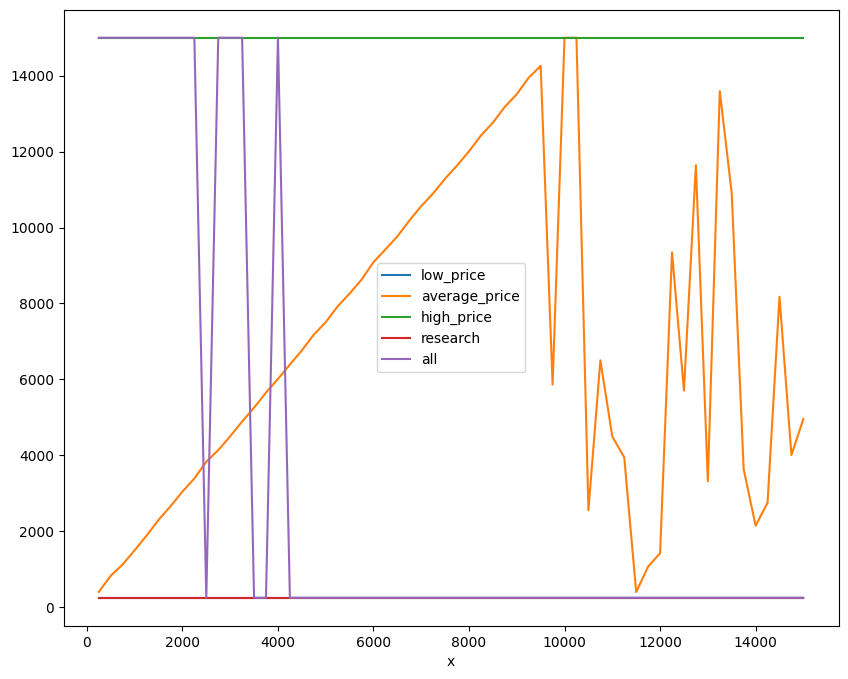

In [63]:
market.plot(figsize=(10,8))

  - Keď je priemerná cena na trhu nízka (~ 3500€ a menej) je dobré maximalizovať predajnú cenu